In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, os
import scipy.stats as stats, scipy.io as sio
from scipy.ndimage import gaussian_filter1d
from neo.io import BlackrockIO
from neo.rawio import BlackrockRawIO
from nilearn import plotting, datasets

# 1. final_neur_df: df with neur info and spike times

In [2]:
# pull in OSort QC
df_preproc = pd.read_csv('../../results/202512/records/preproc.csv')[['channel', 'unit', 'keep']]
df_preproc['keep'] = df_preproc['keep'].fillna(0)
df_preproc

,channel,unit,keep
0,1,596,0.0
1,1,612,0.0
2,2,1432,0.0
3,2,1502,0.0
4,2,1543,0.0
...,...,...,...
85,30,156,0.0
86,31,182,0.0
87,31,188,0.0
88,32,167,0.0


In [3]:
# get [clustIDs] where df[keep] = 0
dropped_clustIDs = df_preproc[df_preproc['keep'] != 1]['unit'].tolist()
dropped_clustIDs.extend([0, 99999999])
print(dropped_clustIDs)

[596, 612, 1432, 1502, 1543, 506, 703, 636, 683, 1469, 2405, 2423, 2457, 2481, 1518, 1755, 1348, 1396, 1553, 1566, 1715, 1772, 976, 1042, 1045, 1433, 1799, 1825, 1953, 1712, 2185, 2769, 3203, 3227, 2308, 2323, 264, 571, 1998, 1747, 1901, 1921, 1585, 1736, 1558, 2261, 2280, 1663, 1678, 1373, 1882, 130, 147, 82, 117, 141, 163, 157, 172, 148, 151, 118, 156, 182, 188, 167, 174, 0, 99999999]


In [4]:
def getclustID2spikes(clustIDs, spikes):
    ''' return dict with keys=unique clusters, and vals = list of corresponding spikes '''
    
    ID_spikes_dict = {}
    for clustID, spike in zip(clustIDs, spikes):

        if clustID in dropped_clustIDs: continue

        if clustID not in ID_spikes_dict: ID_spikes_dict[clustID] = [] # init

        ID_spikes_dict[clustID].append(spike)

    return ID_spikes_dict

### create initial df with channel, clustID, spikes, #spikes, avgFR
 

In [5]:
samp_rate = 1000000
neur_spikes_df = []

data_dir = '../../results/202512/osort_mat/sort/5'

for channel_num in range(len(os.listdir(data_dir))):

    channel_mat = sio.loadmat(f'{data_dir}/A{channel_num+1}_sorted_new.mat')

    # get (1 * n_spikes) clusterID & spiketimes
    clust_IDs = channel_mat['assignedNegative'][0]
    spikes = channel_mat['newTimestampsNegative'][0]

    # get clusterID: [spikes]
    ID_spikes_dict = getclustID2spikes(clust_IDs, spikes)

    # 1 row per clustID
    clust_df = pd.DataFrame([
        {
            "channel": channel_num + 1,
            "clustID": clustID,
            "spikes": np.array(spikes)/samp_rate, #[spike/samp_rate for spike in spikes],
            "#spikes": len(spikes),
            "avgFR": len(spikes) / ((spikes[-1] - spikes[0]) / samp_rate),
        }
        for clustID, spikes in ID_spikes_dict.items()
    ])
    neur_spikes_df.append(clust_df)

neur_spikes_df = pd.concat(neur_spikes_df, ignore_index=True)


### old_channel -> new_channel -> region -> coordinates -> atlas regions

In [6]:
# old channels (1:32) -> new channels (97:128)
raw = BlackrockRawIO(filename="../../results/202512/raw/datafile_202512b002.ns6", nsx_to_load=[6])
raw.parse_header()

sig = raw.header['signal_channels']        # 1-D structured array
chan_ids   = sig['id'].astype(int)         # true Blackrock ChannelIDs (ordered)

old2new_chanID = dict(zip(range(1,33), chan_ids))
neur_spikes_df['old_channel'] = neur_spikes_df['channel'].copy()
neur_spikes_df['channel'] = neur_spikes_df['old_channel'].map(old2new_chanID).fillna(neur_spikes_df['old_channel']).astype(float)
print(np.unique(neur_spikes_df['channel']))
neur_spikes_df

[ 98. 101. 102. 103. 104. 105. 106. 107. 108. 109. 111. 112. 113. 116.]


,channel,clustID,spikes,#spikes,avgFR,old_channel
0,98.0,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888,2
1,101.0,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957,5
2,102.0,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268,6
3,102.0,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394,6
4,102.0,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609,6
5,103.0,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596,7
6,104.0,2410,"[2.8733333333333335, 3.5848333333333335, 3.852...",2370,1.465269,8
7,104.0,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847,8
8,105.0,1938,"[0.6124666666666667, 0.7821333333333333, 1.033...",8664,5.346766,9
9,105.0,1892,"[2.8222333333333336, 4.503333333333334, 5.6112...",3353,2.076493,9


In [7]:
# channels -> regions
channelInfo = sio.loadmat('../../results/202512/records/202512_DI_ChannelMap.mat')
channelMap = channelInfo['ChannelMap1'].flatten()
labelMap = channelInfo['LabelMap'].flatten()
labelMap = np.array([str(label.squeeze()) for label in labelMap])  # convert to str

# dict after removing nan keys
nan_mask = ~np.isnan(channelMap)
channel2label = dict(zip(channelMap[nan_mask], labelMap[nan_mask]))

neur_spikes_df['region'] = neur_spikes_df['channel'].map(channel2label).fillna(neur_spikes_df['channel']).apply(lambda x: str(x))
print(neur_spikes_df['region'].unique())


['mLOFC2' 'mLOFC5' 'mLOFC6' 'mLOFC7' 'mLOFC8' 'mLACC1' 'mLACC2' 'mLACC3'
 'mLACC4' 'mLACC5' 'mLACC7' 'mLACC8' 'mRHIP1' 'mRHIP4']


In [8]:
# regions -> coords

def clean_entry(x):
    while isinstance(x, (np.ndarray, list)):
        x = x[0]
    if isinstance(x, (bytes, bytearray)):
        x = x.decode("utf-8", errors="ignore")
    return str(x)

# load
electrodeInfo = sio.loadmat('../../results/202512/records/202512_DI_Electrodes.mat')
ElecMapRaw   = pd.DataFrame(electrodeInfo['ElecMapRaw'])
ElecXYZRaw   = pd.DataFrame(electrodeInfo['ElecXYZRaw'])
ElecAtlasRaw = pd.DataFrame(electrodeInfo['ElecAtlasRaw'])

atlas_index = 0 # NMM

# clean
region_s = ElecMapRaw[0].apply(clean_entry)                    # Series of regions
atlas_s  = ElecAtlasRaw.iloc[:, atlas_index].apply(clean_entry)  # Series of atlas regions

# build small tables
region2id_df = pd.DataFrame({"region": region_s.values,
                             "ID": np.arange(len(region_s))})
id2xyz_df = ElecXYZRaw.reset_index().rename(columns={'index':'ID', 0:'x', 1:'y', 2:'z'})
# xyz2atlasRegions = pd.DataFrame({"ID": np.arange(len(atlas_s)),
#                                  "atlas_region": atlas_s.values})

# merge
final_neur_df = (neur_spikes_df
                .merge(region2id_df, on='region', how='left')
                .merge(id2xyz_df, on='ID', how='left')
                # .merge(xyz2atlasRegions, on='ID', how='left')
                )
final_neur_df = final_neur_df.drop(columns=['ID'])

### inspect

In [9]:
eg_spikes = final_neur_df['spikes'].iloc[0]
print(f'last 5 spikes (s): {eg_spikes[-5:]}')
print(f'last 5 spikes (min): {eg_spikes[-5:]/60}')
n_neurs = len(final_neur_df)
final_neur_df

last 5 spikes (s): [1620.1233     1620.19223333 1620.53116667 1620.94453333 1621.08233333]
last 5 spikes (min): [27.002055   27.00320389 27.00885278 27.01574222 27.01803889]


,channel,clustID,spikes,#spikes,avgFR,old_channel,region,x,y,z
0,98.0,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888,2,mLOFC2,-0.111605,42.570655,-15.682235
1,101.0,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957,5,mLOFC5,-1.311382,42.570655,-15.682235
2,102.0,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268,6,mLOFC6,-2.511159,42.570655,-15.682235
3,102.0,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394,6,mLOFC6,-2.511159,42.570655,-15.682235
4,102.0,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609,6,mLOFC6,-2.511159,42.570655,-15.682235
5,103.0,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596,7,mLOFC7,-2.511159,40.172309,-15.682235
6,104.0,2410,"[2.8733333333333335, 3.5848333333333335, 3.852...",2370,1.465269,8,mLOFC8,-2.511159,41.371482,-15.682235
7,104.0,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847,8,mLOFC8,-2.511159,41.371482,-15.682235
8,105.0,1938,"[0.6124666666666667, 0.7821333333333333, 1.033...",8664,5.346766,9,mLACC1,-0.111605,32.977269,18.278047
9,105.0,1892,"[2.8222333333333336, 4.503333333333334, 5.6112...",3353,2.076493,9,mLACC1,-0.111605,32.977269,18.278047


## plot electrode location

In [10]:
# template = datasets.load_mni152_template()

# coords = np.array([[ -0.111605,  42.570655, -15.682235],   # lOFC
#                    [ -0.111605,  32.977269,  18.278047],   # lACC
#                    [ 17.885046,   1.399040, -12.885506]])  # rHIP
# coord_regions  = ['lOFC', 'lACC', 'rHIP']
# colors = {'lOFC':'red', 'lACC':'cyan', 'rHIP':'orange'}
# marker_size = 20
# # x = sagittal, y = coronal, z = axial

# # 1. axial
# # fix z (axial)
# axial_cut = 0
# coords_ax = coords.copy()
# coords_ax[:,2] = axial_cut
# disp1 = plotting.plot_anat(template, display_mode='z', cut_coords=[axial_cut],
#                            cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
# for (x,y,z), name in zip(coords_ax, coord_regions):
#     disp1.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])
    
# # 2. sagittal (x=0)
# sag1_cut = 0
# coords_sag1 = coords.copy()
# coords_sag1[:,0] = sag1_cut
# disp2 = plotting.plot_anat(template, display_mode='x', cut_coords=[sag1_cut],
#                            cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
# for (x,y,z), name in zip(coords_sag1, coord_regions):
#     disp2.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])

# # 3. coronal (y=30)
# cor_cut = 0
# coords_cor = coords.copy()
# coords_cor[:,1] = cor_cut
# disp4 = plotting.plot_anat(template, display_mode='y', cut_coords=[cor_cut],
#                            cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
# for (x,y,z), name in zip(coords_cor, coord_regions):
#     disp4.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])

# plotting.show()

# print(colors)

# 2. clean_trigs_df with trig times from .nev

In [11]:
# load
io = BlackrockIO('../../results/202512/raw/datafile_202512b002.nev')
seg = io.read_block(lazy=False).segments[0]
dig_ev = [ev for ev in seg.events if "digital" in ev.name.lower()][0]

# map codes to labels
code_map = {
    10: "block started",
    20: "baseline started",
    30: "stim started",
    40: "delay started",
    50: "task started",
    51: "marker moved",
    52: "left pressed",
    53: "left released",
    54: "right pressed",
    55: "right released",
    56: "response submitted",
    60: "anticipation started",
    70: "feedback started",
    80: "block ended",
}

# build df
df_trigs = pd.DataFrame({
    "trigger": dig_ev.labels.astype(int),
    "time": dig_ev.times.magnitude
})
df_trigs["event"] = df_trigs["trigger"].map(code_map)

clean_trigs_df = df_trigs[3:]
print(clean_trigs_df.head(15))


    trigger       time                 event
3        10  36.379967         block started
4        20  70.978933      baseline started
5        30  71.864133          stim started
6        40  72.858367         delay started
7        50  74.342867          task started
8        51  75.375000          marker moved
9        52  75.375133          left pressed
10       53  75.974967         left released
11       56  76.374967    response submitted
12       60  76.375833  anticipation started
13       70  76.624967      feedback started
14       20  77.625233      baseline started
15       30  78.609500          stim started
16       40  79.608367         delay started
17       50  81.044033          task started


In [12]:
# checks
n_blocks = sum(clean_trigs_df['event'] == 'block started')
n_stim = sum(clean_trigs_df['event'] == 'stim started')
n_delay = sum(clean_trigs_df['event'] == 'delay started')
n_task = sum(clean_trigs_df['event'] == 'task started')
n_feedback = sum(clean_trigs_df['event'] == 'feedback started')
print(n_blocks, n_stim, n_delay, n_task, n_feedback)


6 240 240 240 240


# 3. subj_df with psychopy trial info

In [13]:
df_subjs = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
subj_df = df_subjs[df_subjs['subj'] == '12'].copy()
subj_df

,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,class_true,class_pred,err_type,signed_err,unsigned_err,...,Rcross.stopped,Mcross.started,Mcross.stopped,Unnamed: 115,Unnamed: 122,invalid,missed,purely_incorrect,stim_ranks,resp_ranks
0,0.0,0.0,-0.400,0.0,-0.38,0.0,0.0,0.0,-0.020,0.020,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,1.5
1,1.0,0.0,-0.148,-0.0,-0.38,0.0,0.0,0.0,0.232,0.232,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,20.0
2,0.0,0.0,-0.308,0.0,-0.34,0.0,0.0,0.0,0.032,0.032,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,7.0
3,1.0,0.0,-0.304,-0.0,-0.34,0.0,0.0,0.0,0.036,0.036,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,8.0
4,0.0,0.0,-0.328,0.0,-0.30,0.0,0.0,0.0,-0.028,0.028,...,NaN,NaN,NaN,NaN,NaN,False,False,False,5.5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1.0,0.0,0.224,0.2,0.34,1.0,1.0,0.0,-0.116,0.116,...,NaN,NaN,NaN,NaN,NaN,False,False,False,34.5,20.0
236,0.0,0.0,0.292,0.2,0.38,1.0,1.0,0.0,-0.088,0.088,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,32.0
237,1.0,0.0,0.252,0.2,0.38,1.0,1.0,0.0,-0.128,0.128,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,23.5
238,0.0,0.0,0.384,0.2,0.38,1.0,1.0,0.0,0.004,0.004,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,38.0


## get spikes & rates per trial & neuron

In [14]:
# bin params
prestart, size, dt = -.25, .02, .001
phases = ['baseline', 'stim', 'delay', 'task', 'feedback']
phase_ends = {}
for phase in phases: phase_ends[phase] = 1.5 if phase == 'delay' else 1

def get_normed_FRs(FRs, base_FRs):
    return FRs / base_FRs.mean(axis=(0, 2), keepdims=True)

def get_phase_spikes_and_FRs(clean_trigs_df, final_neur_df, phase, prestart=prestart, size=size, dt=dt):
    ''' for each trial and neuron, get spike times and smoothed FRs (Hz) in phase window
        clean_trigs_df: trig times 
        final_neur_df: spike times per neur '''
    
    phase_end = phase_ends[phase]
    # if phase == 'baseline': prestart = .3 # to prevent spillover from feedback

    # bin edges & centers for hists & plots
    bin_edges = np.arange(prestart, phase_end + dt, dt)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # avg of start & phase_end edges
    n_bins = len(bin_edges) - 1

    # get 240 start times of this phase
    phase_start_rows = clean_trigs_df[clean_trigs_df['event'] == f'{phase} started'].index
    phase_starts = clean_trigs_df.loc[phase_start_rows, 'time'].values
    assert len(phase_starts) == 240
    # phase_starts_df = clean_trigs_df[clean_trigs_df['event'] == f'{phase} started']
    # assert len(phase_starts_df) == 240

    # 3d arr for spikes_times and binned_FRs
    trial_neur_spikes = np.empty((len(phase_starts), len(final_neur_df)), dtype=object)
    trial_neur_FRs = np.zeros((len(phase_starts), len(final_neur_df), n_bins))

    # for phase_trial_i, (_, phase_trial_row) in enumerate(phase_starts_df.iterrows()):
    for trial_idx, trial_phase_start in enumerate(phase_starts):

        for neur_idx, (_, neur_row) in enumerate(final_neur_df.iterrows()):
        # for neur_idx, (_, neur_row) in enumerate(final_neur_df):
            spike_train = np.zeros(n_bins)

            # 1. spikes
            trial_phase_spikes = neur_row['spikes'][(neur_row['spikes'] >= trial_phase_start + prestart) &
                                                    (neur_row['spikes'] <= trial_phase_start + phase_end)]
            trial_phase_spikes = trial_phase_spikes - trial_phase_start # align

            # 2. FRs
            # histogram counts → Hz
            counts, _ = np.histogram(trial_phase_spikes, bins=bin_edges)
            spike_train = counts.astype(float) / dt
            # smooth
            smooth_spike_train = gaussian_filter1d(spike_train, sigma=size/dt, mode='reflect', truncate=3.0)

            # finally, store
            trial_neur_spikes[trial_idx, neur_idx] = trial_phase_spikes
            trial_neur_FRs[trial_idx, neur_idx, :] = smooth_spike_train

    return trial_neur_spikes, trial_neur_FRs, bin_centers

# baseline spikes/FRs for norming
base_spikes, base_FRs, bin_centers = get_phase_spikes_and_FRs(clean_trigs_df, final_neur_df, 'baseline')

## create contrasts

In [27]:
def get_contrast_in_phase(clean_trigs_df, final_neur_df, subj_df, phase, contrast):
    ''' for particular contrast, in a particular phase, draw out spikes & FRs
        clean_trigs_df: trig times
        final_neur_df: spike times
        subj_df: trial info '''
    
    print(f'contrast: {contrast}, phase: {phase}')

    # get spikes/FRs for all trials/neurons in this phase
    spikes, FRs, bin_centers = get_phase_spikes_and_FRs(clean_trigs_df, final_neur_df, phase, prestart, size, dt)

    if contrast =='stim':
        cond1_ids = subj_df[subj_df['stim_pos_aligned'] > .0].index
        cond2_ids = subj_df[subj_df['stim_pos_aligned'] < -.0].index
        cond1_label, cond2_label = 'flat (curv) stims', 'curv (flat) stims'
    elif contrast =='context':
        cond1_ids = subj_df[subj_df['stim_pos_aligned'] > subj_df['div_pos_aligned']].index
        cond2_ids = subj_df[subj_df['stim_pos_aligned'] < subj_df['div_pos_aligned']].index
        cond1_label, cond2_label = 'gain', 'loss' 
    # needs to be changed
    elif contrast =='difficulty':
        subj_df['relative_dist'] = abs(subj_df['stim_pos_aligned'] - subj_df['div_pos_aligned'])
        cond1_ids = subj_df[abs(subj_df['relative_dist']) > 0.1].index
        cond2_ids = subj_df[abs(subj_df['relative_dist']) < 0.1].index
        cond1_label, cond2_label = 'easy', 'hard'

    elif contrast == 'conditions':
        cond1_ids = subj_df[subj_df['condition'] == 'rew_comp'].index
        base_ids = subj_df[subj_df['condition'] == 'baseline'].index
        cond2_ids = subj_df[subj_df['condition'] == 'pen_comp'].index
        cond1_label, base_label, cond2_label = 'gain_expanded', 'baseline', 'loss_expanded'
    elif contrast == 'baseline vs compressed conditions':
        cond1_ids = subj_df[subj_df['condition'] != 'baseline'].index
        cond2_ids = subj_df[subj_df['condition'] == 'baseline'].index
        cond1_label, cond2_label = 'comp', 'base'
    elif contrast == 'outcome':
        cond1_ids = subj_df[subj_df['outcome'] == 3].index
        cond2_ids = subj_df[subj_df['outcome'] == 1].index
        cond1_label, cond2_label = '3 coins', '1 coin'
    else:
        raise ValueError('Invalid contrast')

    print('#trials should typically be 240/#contrasts')
    n_contrasts = 3 if contrast == 'conditions' else 2
    # assert spikes[cond1_ids, :].shape[0] == 240 / n_contrasts
    # assert spikes[cond2_ids, :].shape[0] == 240 / n_contrasts

    print('spikes (#trials, #neurs)')
    print(f'\t{cond1_label}: {spikes[cond1_ids, :].shape}')
    print(f'\t{cond2_label}: {spikes[cond2_ids, :].shape}')
    if contrast == 'conditions': print(f'\t{base_label}: {spikes[base_ids, :].shape}') # extra contrast for 'conditions'
    
    print('rates (#trials, #neurs, #bins)')
    print(f'\t{cond1_label}: {FRs[cond1_ids, :, :].shape}')
    print(f'\t{cond2_label}: {FRs[cond2_ids, :, :].shape}')
    if contrast == 'conditions': print(f'\t{base_label}: {FRs[base_ids, :, :].shape}') # extra contrast for 'conditions'

    return spikes, FRs, bin_centers, cond1_ids, cond2_ids, cond1_label, cond2_label


### plots

a. check rasters

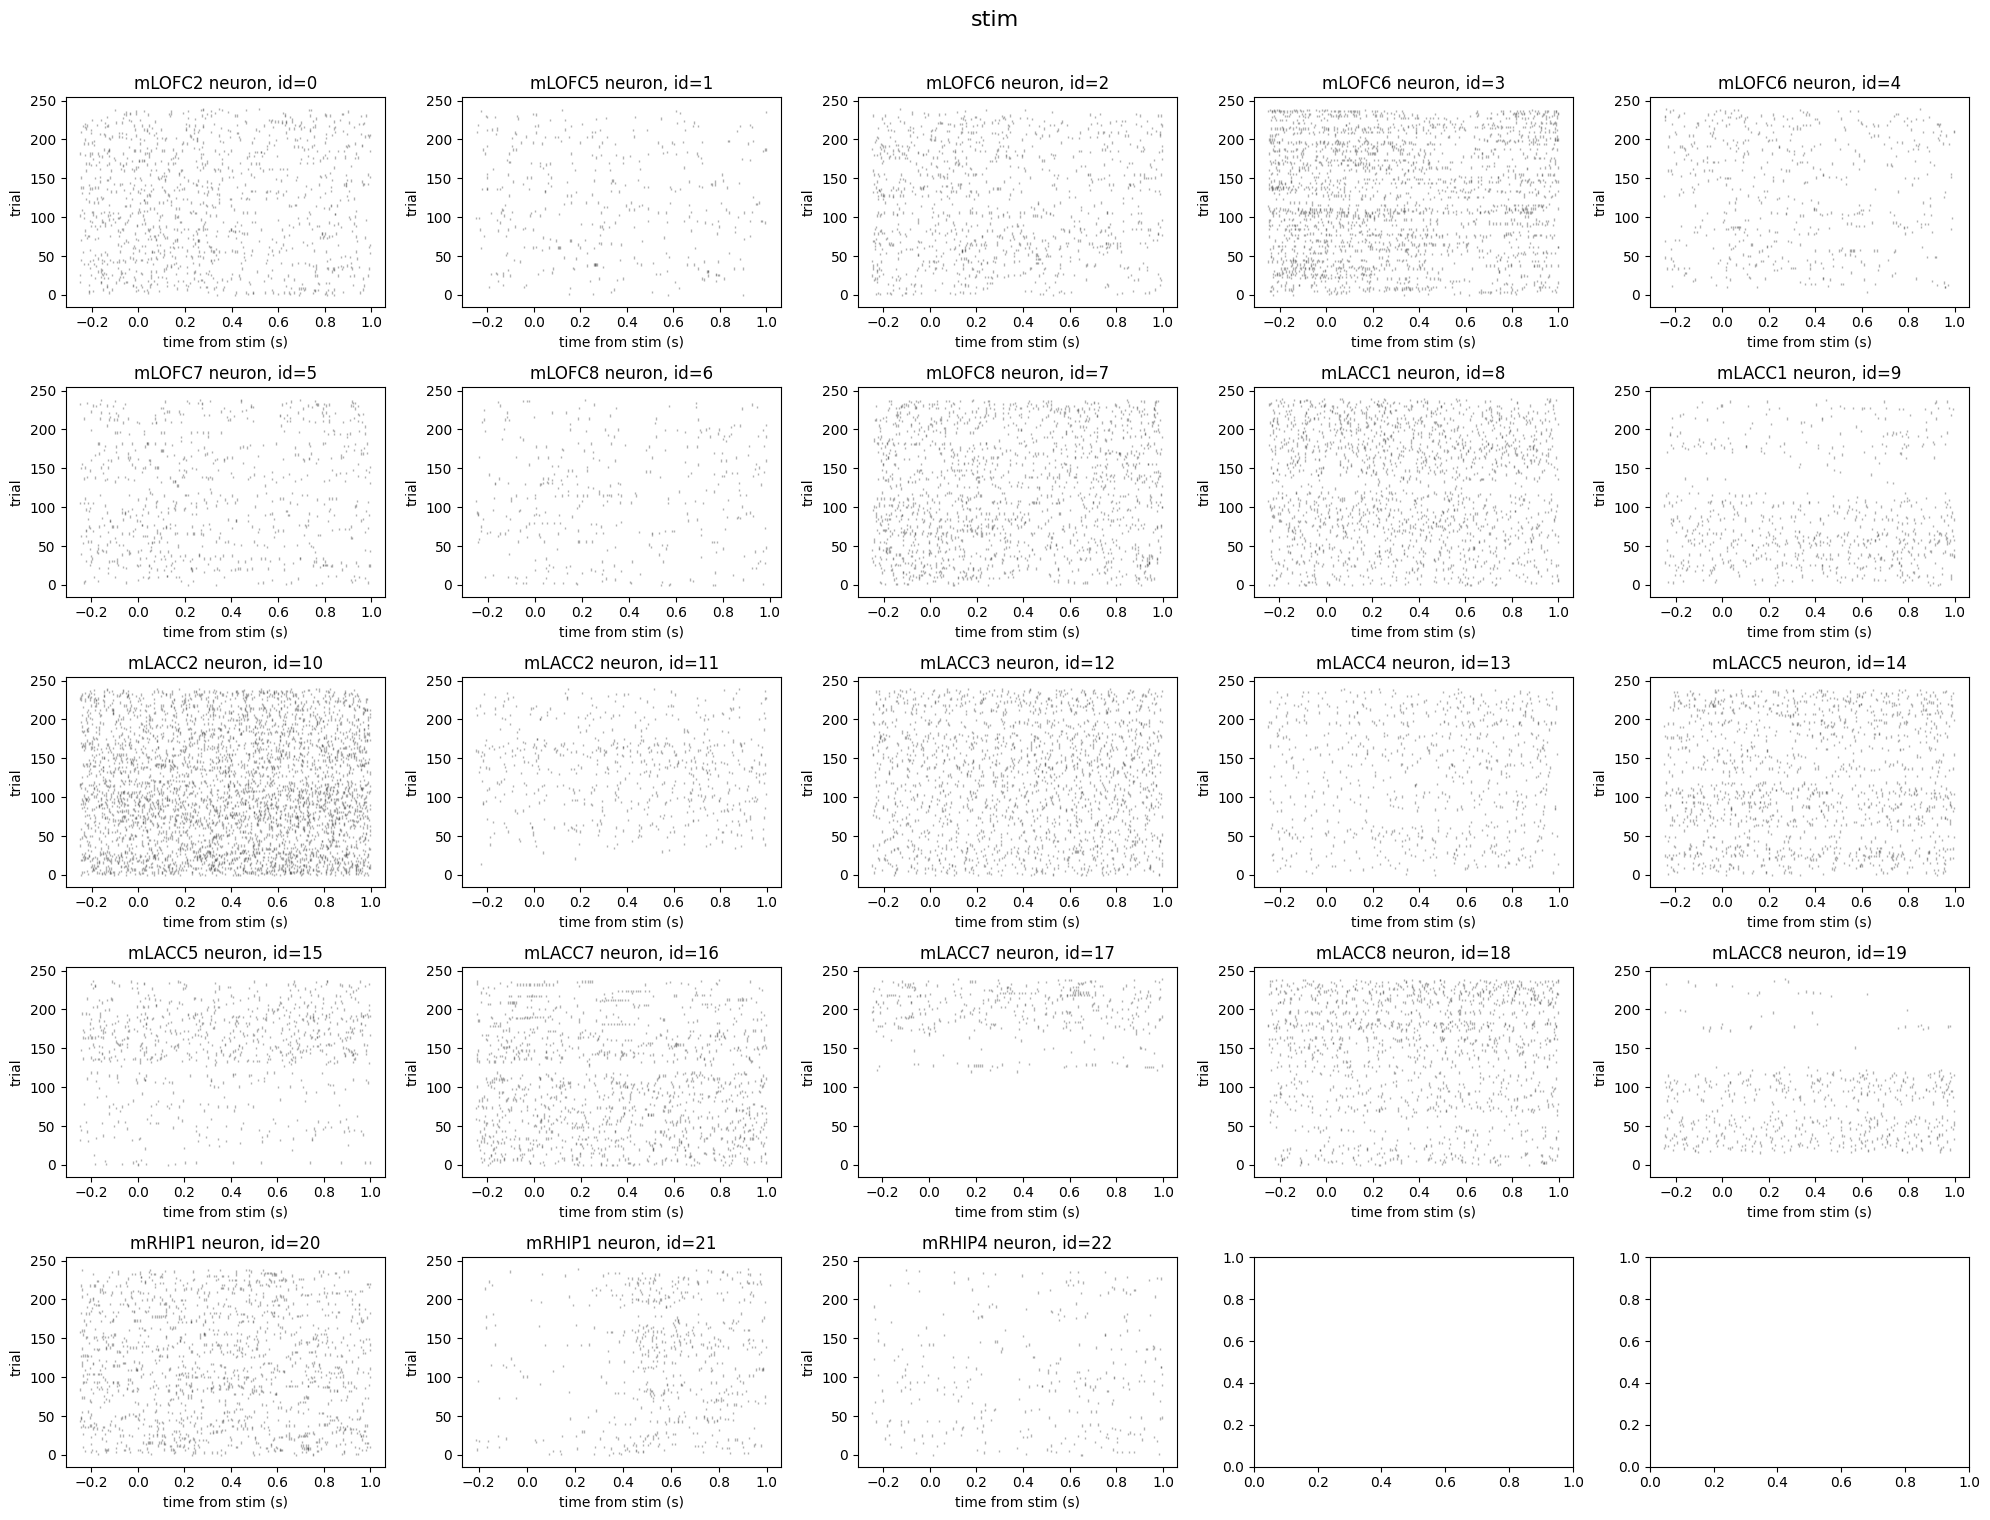

In [28]:
phase = 'stim'
spikes, FRs, bin_centers = get_phase_spikes_and_FRs(clean_trigs_df, final_neur_df, phase, prestart, size, dt)
normed_FRs = get_normed_FRs(FRs, base_FRs)

n_rows, n_cols = 5, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_id in range(n_neurs):
    axs[ax].eventplot(spikes[:, neur_id], orientation='horizontal', colors='k', alpha=0.3, linewidths=1., linelengths=3.)
    axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_id]} neuron, id={neur_id}',
                ylabel='trial', xlabel=f'time from {phase} (s)')#, xlim=[0, dur[phase]])
    ax += 1

plt.suptitle(phase, y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


In [29]:
dropped_neur_ids = [9, 11, 17, 19, 21]

b. contrasts

contrast: difficulty, phase: task
#trials should typically be 240/#contrasts
spikes (#trials, #neurs)
	easy: (144, 23)
	hard: (80, 23)
rates (#trials, #neurs, #bins)
	easy: (144, 23, 1250)
	hard: (80, 23, 1250)


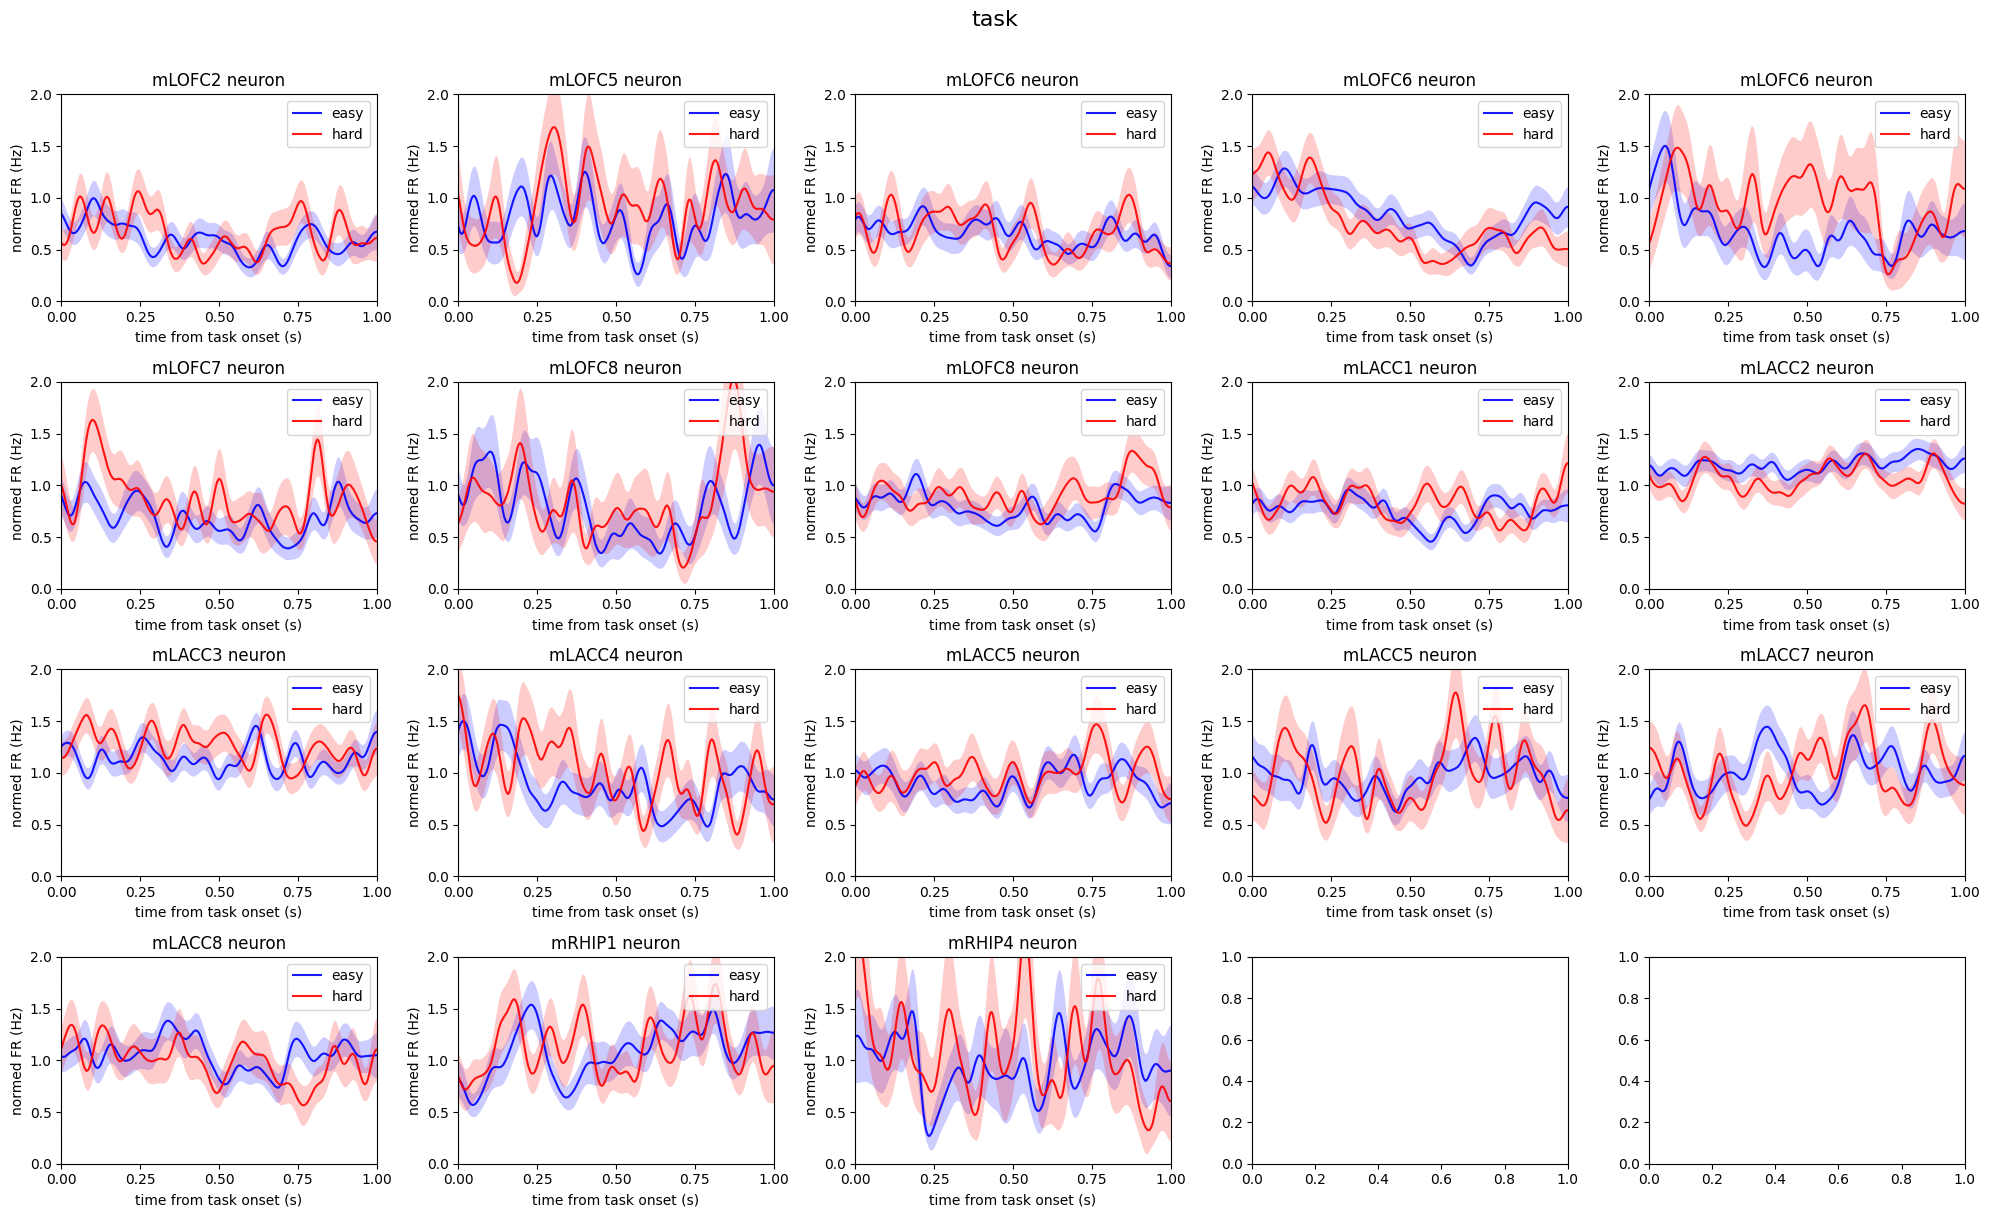

In [30]:
# phases = ['baseline', 'stim', 'task', 'delay', 'feedback']
# contrasts = ['stim', 'context', 'difficulty', 'conditions', 'baseline vs compressed conditions', 'outcome'] 
phase, contrast = 'task', 'difficulty'
spikes, FRs, bin_centers, cond1_ids, cond2_ids, cond1_label, cond2_label = get_contrast_in_phase(clean_trigs_df, final_neur_df, subj_df, phase, contrast)
normed_FRs = get_normed_FRs(FRs, base_FRs)

n_rows, n_cols = 4, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_id in range(n_neurs):

    if neur_id in dropped_neur_ids: continue

    # choose between showing 2 or 3 contrasts
    if contrast!= 'conditions': zipped = zip([cond1_label, cond2_label], [cond1_ids, cond2_ids], ['b', 'r'])
    else: zipped = zip([cond1_label, base_label, cond2_label], [cond1_ids, base_ids, cond2_ids], ['b', 'g', 'r'])

    for contrast_label, contrast_ids, color in zipped:
        data = normed_FRs[contrast_ids, neur_id, :]
        mu = data.mean(axis=0)
        sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
        axs[ax].plot(bin_centers, mu, color=color, alpha=0.9, label=contrast_label)
        axs[ax].fill_between(bin_centers, mu - sderr, mu + sderr, color=color, alpha=0.2, linewidth=0)

    axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
    axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_id]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {phase} onset (s)',
                xticks=np.linspace(-.25, 1.5, 8), xlim=[0, phase_ends[phase]], ylim=[0, 2])
    axs[ax].legend(loc='upper right')
    ax += 1

plt.suptitle(phase, y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


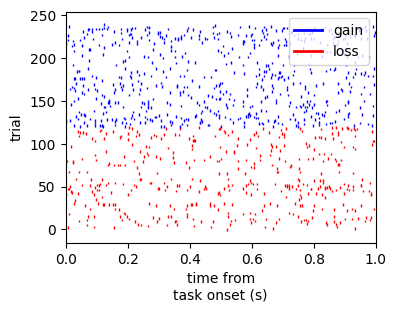

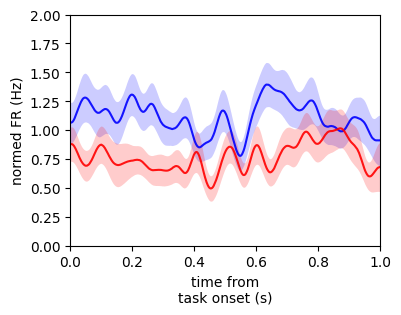

In [22]:
# get unique rowID where region = 'mLACC5'. there might be multiple
reg = 'mLACC5'
neur_id = neur_spikes_df[neur_spikes_df['region'] == reg].index[0]

# 1. raster
plt.figure(figsize=(4,3))
# plt.title(f'{neur_spikes_df["region"].iloc[neur_id]} neuron')
if contrast!= 'conditions':
    raster_list = list(spikes[cond2_ids, neur_id]) + list(spikes[cond1_ids, neur_id])
    color_list = ['red'] * len(cond2_ids) + ['blue'] * len(cond1_ids)
else:
    raster_list = list(spikes[cond1_ids, neur_id]) + list(spikes[base_ids, neur_id]) + list(spikes[cond2_ids, neur_id])
    color_list = ['blue'] * len(cond1_ids) + ['black'] * len(base_ids) + ['red'] * len(cond2_ids)
plt.eventplot(raster_list, orientation='horizontal', colors=color_list, linewidths=1.0, linelengths=3.0)
plt.ylabel('trial')
plt.xlabel(f'time from\n{phase} onset (s)')
plt.xlim([-.0, phase_ends[phase]])
plt.legend(handles=[plt.Line2D([0], [0], color='b', lw=2, label=cond1_label),
                    plt.Line2D([0], [0], color='r', lw=2, label=cond2_label)] + 
                   ([plt.Line2D([0], [0], color='g', lw=2, label=base_label)] if contrast=='conditions' else []),
           loc='upper right')
plt.show()

# 2. psth
plt.figure(figsize=(4,3))

# choose between showing 2 or 3 contrasts
if contrast!= 'conditions': zipped = zip([cond1_label, cond2_label], [cond1_ids, cond2_ids], ['b', 'r'])
else: zipped = zip([cond1_label, base_label, cond2_label], [cond1_ids, base_ids, cond2_ids], ['b', 'g', 'r'])

for contrast_label, contrast_ids, color in zipped:
    data = normed_FRs[contrast_ids, neur_id, :]
    mu = data.mean(axis=0)
    sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
    plt.plot(bin_centers, mu, color=color, alpha=0.9, label=contrast_label)
    plt.fill_between(bin_centers, mu - sderr, mu + sderr, color=color, alpha=0.2, linewidth=0)

plt.ylabel('normed FR (Hz)')
plt.xlabel(f'time from\n{phase} onset (s)')
plt.xlim([-.0, phase_ends[phase]])
plt.ylim([0, 2])
plt.show()


c. phase neurons

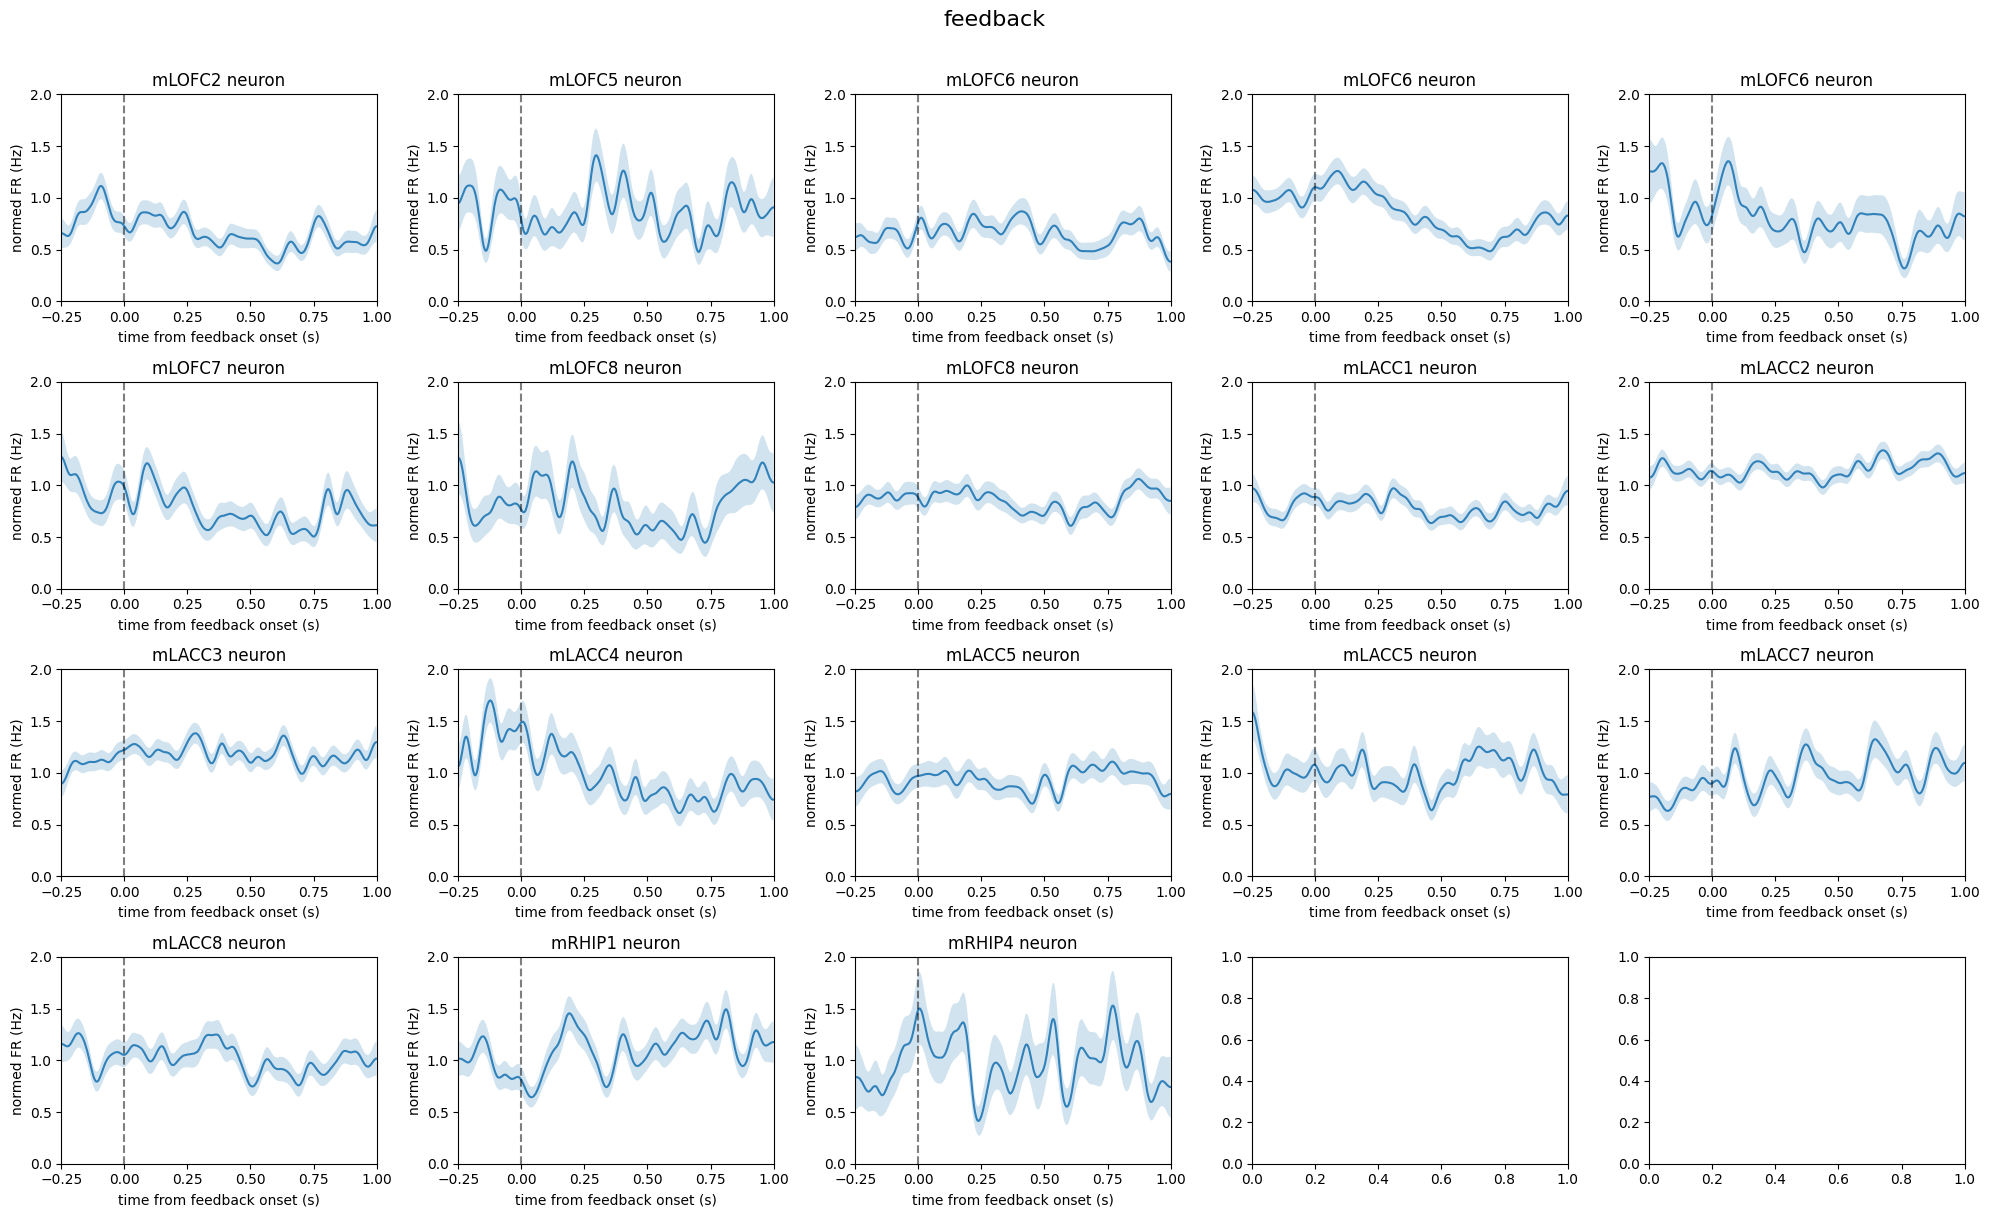

In [24]:
phase = 'feedback'
n_rows, n_cols = 4, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_i in range(n_neurs):

    if neur_i in dropped_neur_ids: continue
    # no norming for baseline itself
    data = normed_FRs[:, neur_i, :] if phase!='baseline' else FRs[:, neur_i, :]
    mu = data.mean(axis=0)
    sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
    axs[ax].plot(bin_centers, mu, alpha=0.9)
    axs[ax].fill_between(bin_centers, mu - sderr, mu + sderr, alpha=0.2, linewidth=0)
    axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
    axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_i]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {phase} onset (s)', xticks=np.linspace(-.25, 1.5, 8), xlim=[prestart, phase_ends[phase]])
    if phase!='baseline': axs[ax].set(ylim=[0, 2])
    ax += 1

plt.suptitle(phase, y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


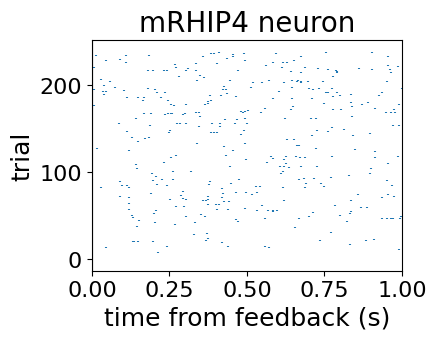

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


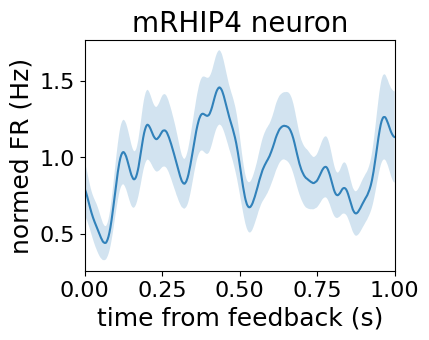

In [ ]:
if phase == 'stim': plot_neur_i = 19
elif phase == 'delay': plot_neur_i = 21
elif phase == 'feedback': plot_neur_i = 4

# raster
plt.figure(figsize=(4,3))
plt.title(f'{neur_spikes_df["region"].iloc[neur_i]} neuron')
plt.eventplot(spikes[phase][:, plot_neur_i], orientation='horizontal')
plt.axvline(0, color='black', linestyle='-')
plt.ylabel('trial')
plt.xlabel(f'time from {phase} (s)')
plt.xlim([-.0, dur[phase]])
plt.savefig(f'../../data/eps_figs/eg_{phase}_neur_raster.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

# psth
plt.figure(figsize=(4,3))
plt.title(f'{neur_spikes_df["region"].iloc[neur_i]} neuron')
data = FRs_normed[phase][:, plot_neur_i, :]
mu = data.mean(axis=0)
sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
plt.plot(bin_centers[phase], mu, alpha=0.9)
plt.fill_between(bin_centers[phase], mu - sderr, mu + sderr, alpha=0.2, linewidth=0)
# plt.axvline(0, color='black', linestyle='-')
plt.ylabel('normed FR (Hz)')
plt.xlabel(f'time from {phase} (s)')
plt.xlim([-.0, dur[phase]])
plt.savefig(f'../../data/eps_figs/eg_{phase}_neur_PSTH.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()


zifest

In [ ]:
# plt.rcParams.update({
#     "axes.titlesize": 20,   # subplot titles
#     "axes.labelsize": 18,   # x/y labels
#     "xtick.labelsize": 16,  # x ticks
#     "ytick.labelsize": 16,  # y ticks
#     "legend.title_fontsize": 16,  # legend title
#     "legend.fontsize": 16,        # legend labels
# })

duration checks for stim & feedback

In [ ]:
# n_rows, n_cols = 1, 2
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
# axs, ax = axs.flatten(), 0

# print(len(subj_df['no_resp_text.started']))
# axs[ax].hist(subj_df['no_resp_text.started']-subj_df['feedback.started'], bins=30)
# axs[ax].set_title('no_resp_text.started - feedback.started (s)')
# ax += 1

# axs[ax].hist(subj_df['target_stim.started']-subj_df['stim.started'], bins=30)
# axs[ax].set_title('target_stim.started - stim.started (s)')

# plt.suptitle('duration checks')
# plt.tight_layout()
# plt.show()